<a href="https://colab.research.google.com/github/ssubbinn/ESAA-OB/blob/main/16%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 이미지 분할

: 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것

ex) 배경 클래스와 객체 클래스로 구성된 이미지가 있다면, 모든 픽셀은 배경 또는 객체 중 하나로 분류

- 의미분할 : 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분
- 인스턴스 분할 : 같은 범주에 속하더라도 서로 다른 객체를 구분하는 개념

### 7-1 데이터셋 준비

- class 1 : 반려동물이 속한 픽셀
- class 2 : 반려동물과 인접한 픽셀
- class 3 : 위에 속하지 않거나 주변 픽셀

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

In [2]:
# 이미지 크기
img_w=128
img_h=128
img_c=3
img_shape=(img_w, img_h, img_c)

# 모델 학습
epoch_num=5
learning_rate=0.0001
buffer_size=1000
batch_size=16

In [3]:
# 텐서플로 데이터셋 로드
ds_str='oxford_iiit_pet'
ds, info=tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteN98UQV/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteN98UQV/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


원본 이미지와 분할 마스크를 전처리하는 함수를 정의

In [4]:
# 이미지 전처리 함수
def preprocessing_image(ds):

  # 원본 이미지
  img=tf.image.resize(ds['image'], (img_w, img_h))
  img=tf.cast(img, tf.float32)/255.0

  # 분할 마스크
  mask=tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
  mask=tf.cast(mask, tf.int32)
  mask=mask-1
  return img, mask

앞에서 정의한 전처리 함수를 훈련 셋, 테스트 셋에 매핑해주고 미니배치로 분할

In [5]:
# 데이터 전처리 파이프라인
train_ds=ds['train'].map(preprocessing_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds=ds['test'].map(preprocessing_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


샘플 배치 선택 - 16개의 샘플이미지와 마스크 이미지가 들어있음

In [6]:
# 샘플 배치 선택
img, mask=next(iter(train_ds))
len(img)

16

첫번째 이미지 출력, 255곱해서 복원

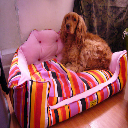

In [7]:
# 샘플 이미지 출력
img=np.array(img[0])*255.0
img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

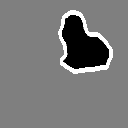

In [8]:
# 샘플 마스크 출력
mask=(np.array(mask[0])/2)*255.0
cv2_imshow(mask)

### 7-2 U-Net 모델

사전학습된 VGG16 모델을 인코더로 활용하는 U-Net 모델을 만들어 본다

먼저 VGG16모델을 최종 레이어 제외하고 불러온다

In [9]:
# VGG16 모델
base_model=tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


VGG 모델은 합성곱 층과 풀링 층을 직렬로 연결한 구조를 갖는다.

(128,128)이 (4,4)로 축소

이 모델을 U-Net의 인코더로 사용할 예정
- 인코더는 원본 이미지 중에서 같은 범주에 속하는 픽셀을 결함하면서 점진적으로 이미지를 더 작은 크기로 축소

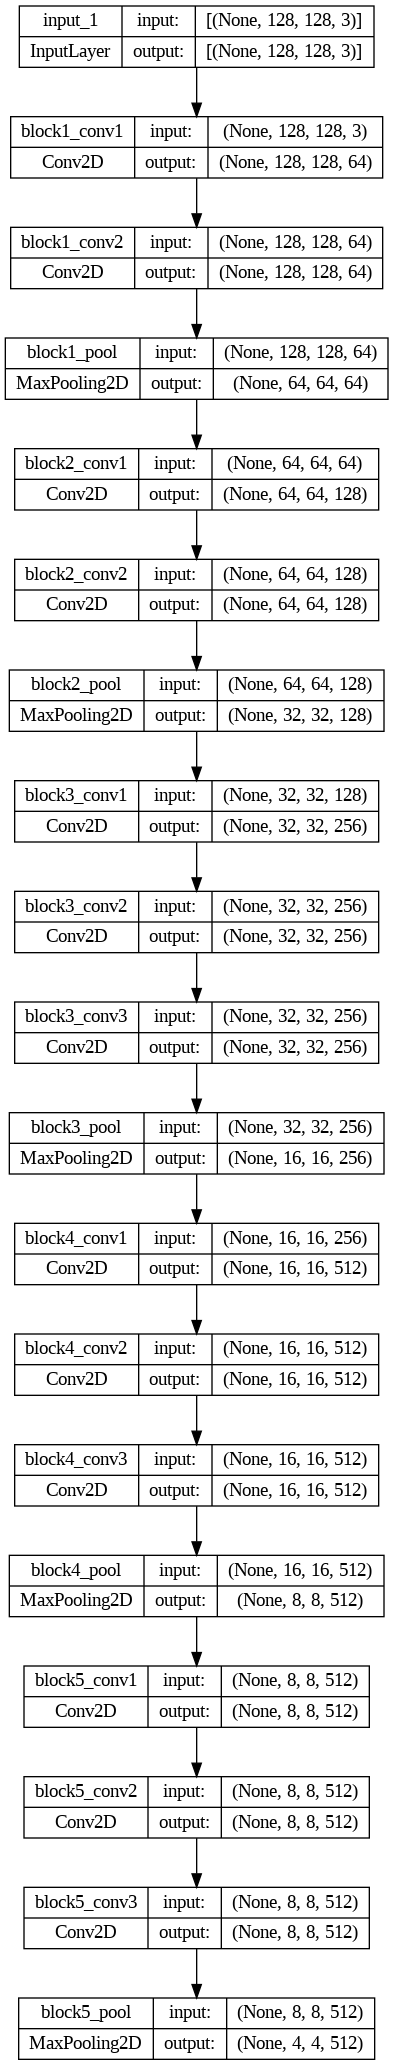

In [10]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

- 만들고자 하는 U-Net 모양을 미리 정하고, 사전 학습된 모델에서 어느 부분의 어떤 shape을 가져올지 정한다. VGG16 모델의 중간 레이어 중 필요한 출력 텐서를 지정해 다양한 피처를 추출하는 인코더 모델을 정의.

- 여기서는 VGG16 모델로부터 5개의 출력을 가져와서 사용. 다음 코드를 보면 1개의 입력과 5개의 출력을 갖는다.

In [11]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model=tf.keras.Model(inputs=[base_model.input],
                       outputs=[base_model.get_layer(name='block5_conv3').output,
                                base_model.get_layer(name='block4_conv3').output,
                                base_model.get_layer(name='block3_conv3').output,
                                base_model.get_layer(name='block2_conv2').output,
                                base_model.get_layer(name='block1_conv2').output])

사전 학습된 파라미터를 업데이트 되지 않도록 고정. 인코더에 그대로 사용한다.

In [12]:
# 파라미터 고정
f_model.trainable=False

인코더 부분에서 5개의 출력을 가져와 디코더의 입력으로 전달하며 업샘플링한다. 업샘플링은 축소된 이미지를 원래 크기로 복원하는 과정.

In [13]:
# U-Net 구조로 모델 정의

i=tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64=f_model(i)

out=tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same')(out_8_8_512)
out=tf.keras.layers.Add()([out, out_16_16_512])

out=tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out=tf.keras.layers.Add()([out, out_32_32_256])

out=tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out=tf.keras.layers.Add()([out, out_64_64_128])

out=tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out=tf.keras.layers.Add()([out, out_128_128_64])

out=tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same')(out)
out=tf.keras.layers.Dense(3, activation='softmax')(out)

unet_model=tf.keras.Model(inputs=[i], outputs=[out])


U-Net 디코더를 구성할 때 입력 텐서와 출력 텐서의 크기를 맞추는 것이 중요. 여기서 인코더의 Conv2D 레이어에 의한 합성곱 변환은 Conv2DTranspose 레이어를 통해 합성곱 연산을 반대 방향으로 되돌릴 수 있다.

U-Net 모델을 시각화해보자. 인코더의 중간 출력이 업샘플링 과정에서 디코더의 중간 출력과 합쳐지는 것을 확인할 수 있다.

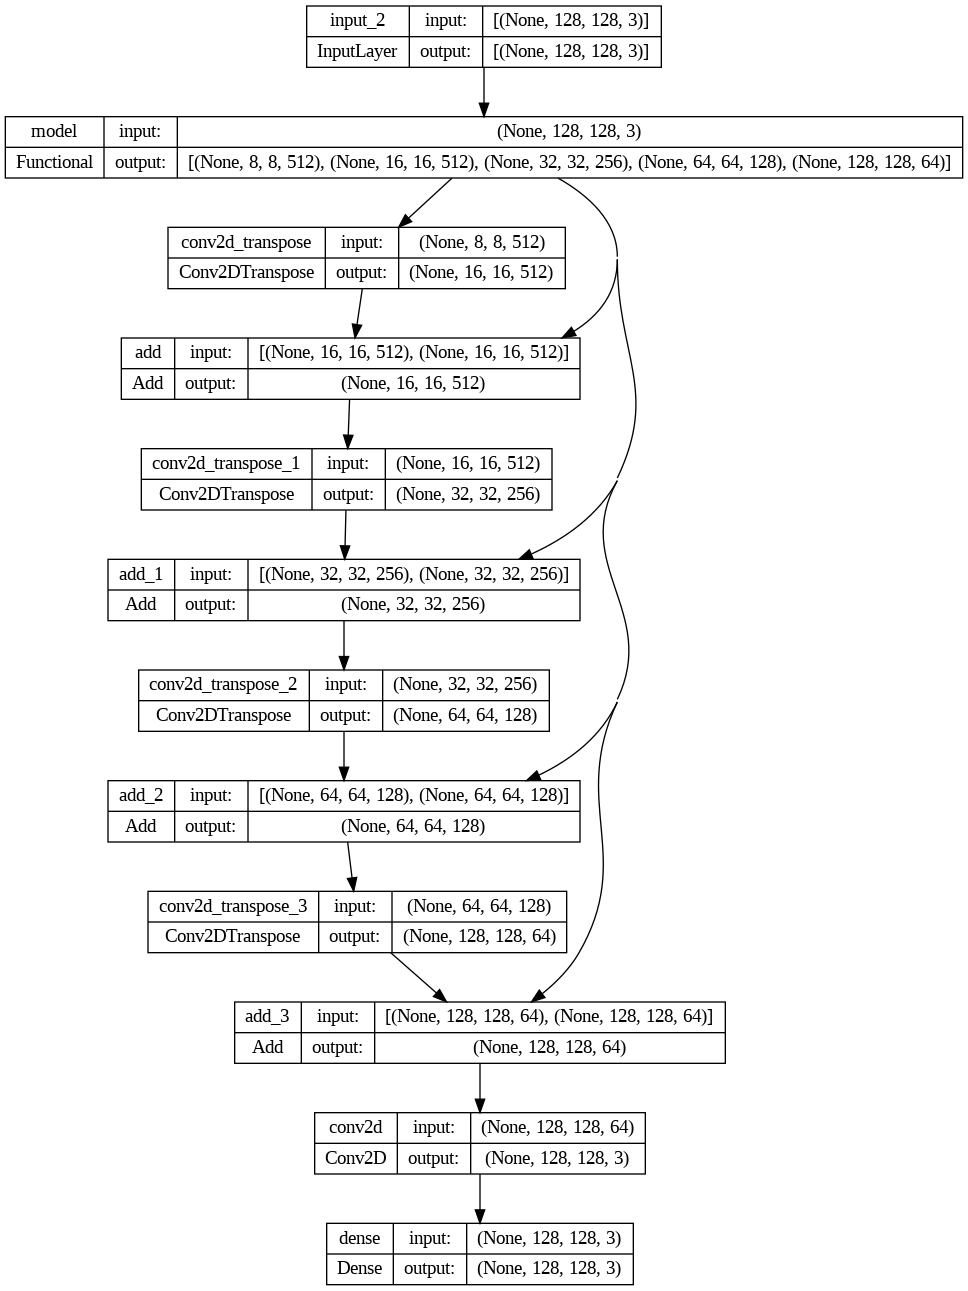

In [14]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [15]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 8, 8, 512),  14714688    ['input_2[0][0]']                
                                 (None, 16, 16, 512                                               
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                          

다중 분류 - Sparsecategoricalcrossentropy

adam 옵티마이저

In [16]:
# 모델 컴파일 및 훈련
loss_f=tf.losses.SparseCategoricalCrossentropy()
opt=tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 33s 73ms/step - loss: 0.9297 - accuracy: 0.6215
Epoch 2/5
230/230 [==============================] - 20s 76ms/step - loss: 0.6013 - accuracy: 0.7698
Epoch 3/5
230/230 [==============================] - 20s 75ms/step - loss: 0.5393 - accuracy: 0.8057
Epoch 4/5
230/230 [==============================] - 21s 79ms/step - loss: 0.4893 - accuracy: 0.8304
Epoch 5/5
230/230 [==============================] - 21s 80ms/step - loss: 0.4647 - accuracy: 0.8393


검증 셋의 배치를 하나 선택하고 predict() 메서드로 이미지 분할 클래스를 예측

1/1 [==============================] - 0s 335ms/step


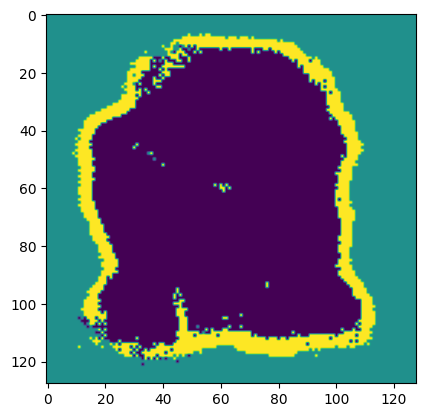

In [17]:
# 1개 매치 (16개 이미지)를 선택
img, mask=next(iter(test_ds))

# 모델 예측
pred=unet_model.predict(img)

# 첫번째 이미지 분할 결과를 출력
pred_img=np.argmax(pred[0], -1)
plt.imshow(pred_img)

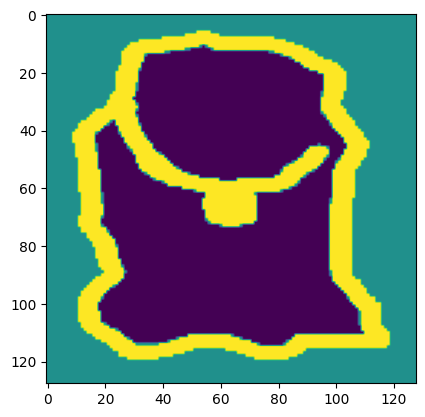

In [18]:
plt.imshow(np.reshape(mask[0],(128,128)))

객체 경계를 찾아내는 것을 확인 가능